Install Sentence Transormers

In [1]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 73.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=f319e2d484bcdda8d284b06ae28c0f1624d5bd2a4ac5a9f8fc29e5b27e684703
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


import libraries and packages

In [2]:
import os
import pickle as pkl
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu
import glob
from sentence_transformers import SentenceTransformer, util
from PIL import Image
from IPython.display import display
from IPython.display import Image as IPImage

filter the warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

Mount google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Total Images 

In [5]:
img_dir='drive/MyDrive/FLickr_8k/Images'
_, _, files = next(os.walk(img_dir))
len(files)

8091

<!-- Loading image features into features  -->

Loading the captions in captions_doc

In [6]:
with open('drive/My Drive/FLickr_8k/captions.txt','r') as f:
  next(f)
  captions_doc=f.read()

mapping images to its captions

In [7]:
mapping={}
for line in tqdm(captions_doc.split('\n')):
  tokens=line.split(',')
  if len(line)<2:
    continue
  image_id,caption = tokens[0],tokens[1:]
  image_id=image_id.split('.')[0]
  caption=" ".join(caption)
  if image_id not in mapping:
    mapping[image_id]=[]
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

total captions

In [8]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)
len(all_captions)

40455

#Preprocessing the captions

**clean_caption** adds the startseq at the start of the caption, endseq at the end of caption, removes all the single letter words and extra spaces from the caption

**clean** goes through all of the captions in mapping and cleans them

In [9]:
def clean_caption(caption):
  caption=caption.lower()
  caption=caption.replace('[^A-Za-z]','')
  caption=caption.replace('\s+',' ')
  caption='startseq '+ " ".join([word for word in caption.split() if len(word)>1])  + ' endseq'
  return caption

def clean(mapping):
  for key,captions in mapping.items():
    for i in range(len(captions)):
      caption=captions[i]
      caption=clean_caption(caption)
      captions[i]=caption

print caption without the 'startseq' and 'endseq'

In [10]:
def print_cap(caption):
    stopwords=['startseq','endseq']
    querywords = caption.split()
    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    result = ' '.join(resultwords)
    return result

In [11]:
mapping['107318069_e9f2ef32de']

['A crowd watching air balloons at night .',
 'A group of hot air balloons lit up at night .',
 'People are watching hot air balloons in the park .',
 'People watching hot air balloons .',
 'Seven large balloons are lined up at nighttime near a crowd .']

preprocessing the captions 

In [12]:
clean(mapping)

In [13]:
mapping['107318069_e9f2ef32de']

['startseq crowd watching air balloons at night endseq',
 'startseq group of hot air balloons lit up at night endseq',
 'startseq people are watching hot air balloons in the park endseq',
 'startseq people watching hot air balloons endseq',
 'startseq seven large balloons are lined up at nighttime near crowd endseq']

**get_similar _query** gives image name and captions similar to the query caption

**get_captions_for_images** gives actual captions of the image from mapping dictionary that we defined earlier

In [14]:
def get_similar_query(query):
  captions=[]
  for key,caps in mapping.items():
    if clean_caption(query) in caps:
      for cap in caps:     
        caption=cap.split()
        captions.append(caption)
        img=key+'.jpg'
      return img,captions

def get_captions_for_images(query):
  img_name=query.filename.split('/')[-1].split('.')[0]
  caps=mapping[img_name]
  captions=[]
  for cap in caps:    
    caption=cap.split()
    captions.append(caption)
  return captions

**captions_for_pred_imgs** returns a single caption of the image

**evaluate_img_caption_bleu** calculates the Bleu score of actual and predicted image's captions, based on a certain threshold less than 1.0 it marks the predicted image as correct or wrong

In [15]:
img_names = list(glob.glob('drive/MyDrive/FLickr_8k/Images/*.jpg'))

def captions_for_pred_imgs(query):
  img_name=query.split('/')[-1].split('.')[0] 
  caps=mapping[img_name]
  captions=[]
  for cap in caps:    
    caption=cap.split()
    captions.append(caption)
  return captions

def evaluate_img_caption_bleu(query,hits):
  predictedd=[]
  if type(query) == str:
    actuall=[get_similar_query(query)[1]]
  else:
    actuall=[get_captions_for_images(query)]
  guesses=[0]*len(hits)
  labels=[1]*len(hits)
  i=0
  print("\nResults")
  for hit in hits:
    display(IPImage(img_names[hit['corpus_id']],width=200))
    cap=img_names[hit['corpus_id']]  
    predicted_imgs_cap=captions_for_pred_imgs(cap)
    bleu_list=[]
    for pred in predicted_imgs_cap:
      bleu=corpus_bleu(actuall,[pred],weights=[1.0,0,0,0])
      bleu_list.append(bleu)
    if max(bleu_list)>=0.5:
      guesses[i]=1
    i+=1
  print(f'\nAccuracy :{accuracy_score(labels,guesses)*100} %')

**evaluate_caption_bleu** calculates the bleu score between actual captions of the query image/caption and captions predicted by the clip model

In [16]:
def evaluate_caption_bleu(query,hits):
  predictedd=[]
  if type(query) == str:
    actuall=[get_similar_query(query)[1]]
  else:
    actuall=[get_captions_for_images(query)]
  for hit in hits:
    cap=all_captions[hit['corpus_id']].split()  
    predictedd.append(cap)
    break
  print("\nResults: ")
  for hit in hits:
    print(print_cap(all_captions[hit['corpus_id']]))
  print(f"\nBleu score is {corpus_bleu(actuall,predictedd,weights=[1.0,0,0,0])}")

#**clip-ViT-B-32** is used to encode the images

In [17]:
image_model = SentenceTransformer('clip-ViT-B-32')

img_emb = image_model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)
BASE_DIR='drive/MyDrive/FLickr_8k'
pkl.dump(img_emb,open(os.path.join(BASE_DIR,'image_embeddings.pkl'),'wb'))

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

#**clip-ViT-B-32-multilingual-v1** is used to encode the captions

In [18]:
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

text_embeddings = text_model.encode(all_captions)
pkl.dump(text_embeddings,open(os.path.join(BASE_DIR,'text_embeddings.pkl'),'wb'))

**util.semantic_search** calculates the cosine similarity between the query embedding and image embeddings and returns the images with top k cosine similarities

**evaluate_img_caption_bleu** gives the accuracy based on bleu score

In [19]:
img_folder = 'drive/My Drive/FLickr_8k/Images/'
with open('drive/My Drive/FLickr_8k/image_embeddings.pkl','rb') as f:  
  img_emb=pkl.load(f)
  
def search_images(query, k):
    if type(query)==str:
      query_emb = text_model.encode([query], convert_to_tensor=True, show_progress_bar=False)
      print("query caption's image")
      display(Image.open(os.path.join(img_dir,get_similar_query(query)[0])))
    else:
      query_emb = image_model.encode([query], convert_to_tensor=True, show_progress_bar=False)
      print("Query Image")
      display(query)
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]
    evaluate_img_caption_bleu(query,hits)

**generate_clip_captions** prints top k captions with the highest cosine similarities

In [20]:
with open('drive/My Drive/FLickr_8k/text_embeddings.pkl','rb') as f:  
  txt_emb=pkl.load(f)
  
def generate_clip_captions(query,k):
  if type(query)==str:
      query_emb = text_model.encode([query], convert_to_tensor=True, show_progress_bar=False)
  else:
      query_emb = image_model.encode([query], convert_to_tensor=True, show_progress_bar=False)
      print("Query: ")
      display(query)
  hits = util.semantic_search(query_emb,txt_emb,top_k=k)[0]
  evaluate_caption_bleu(query,hits)

#CAPTION -> IMAGE

query caption's image


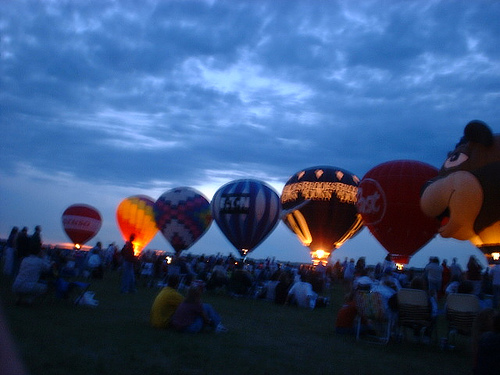


Results


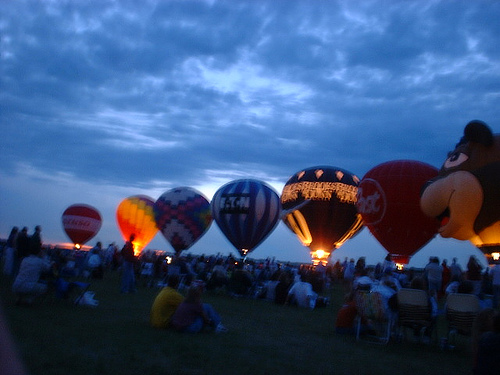

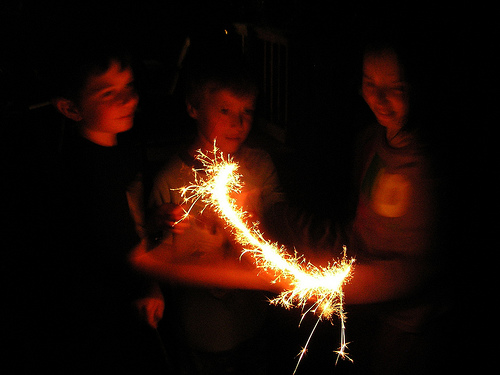

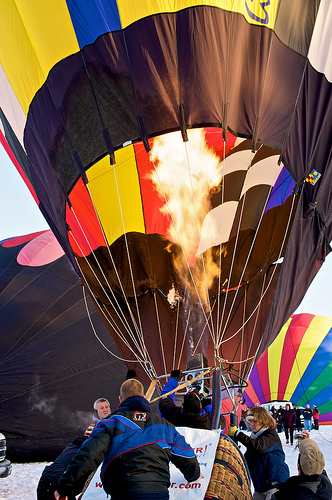

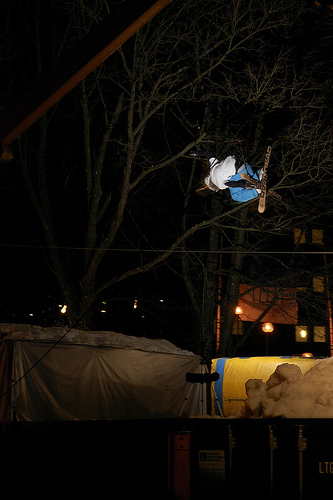

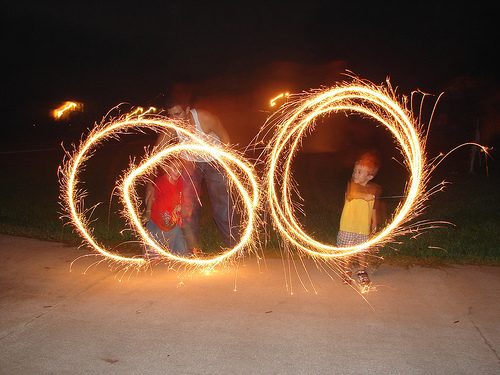


Accuracy :80.0 %


In [21]:
search_images('A group of hot air balloons lit up at night',k=5)

#IMAGE -> IMAGE

Query Image


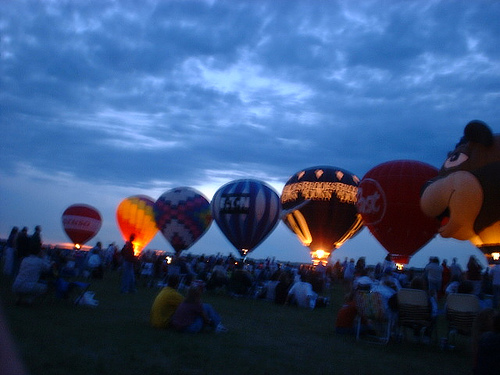


Results


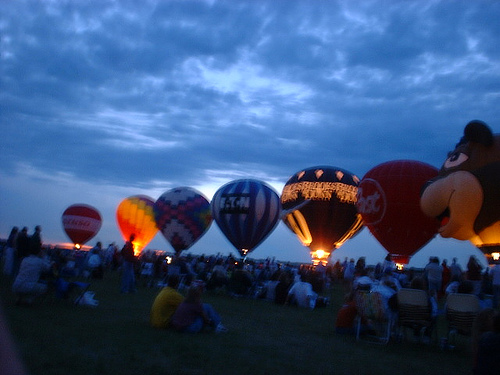

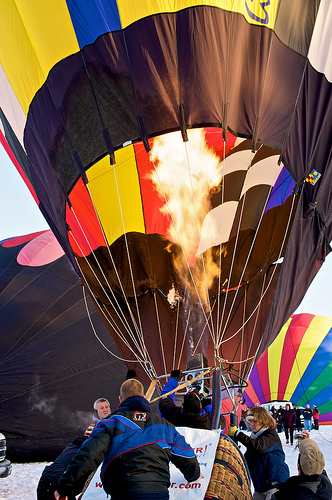

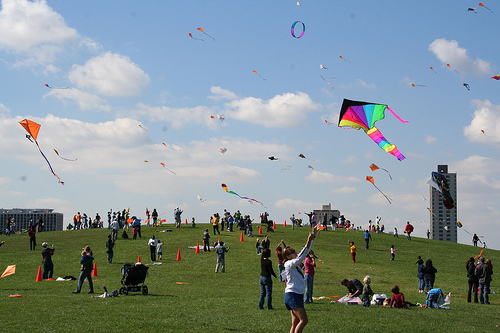

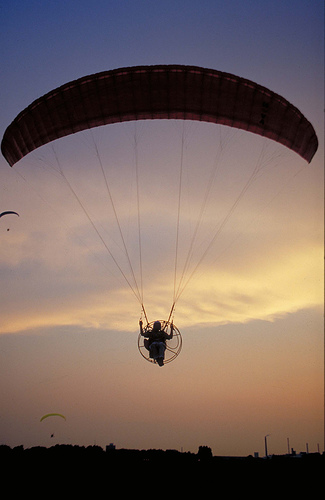

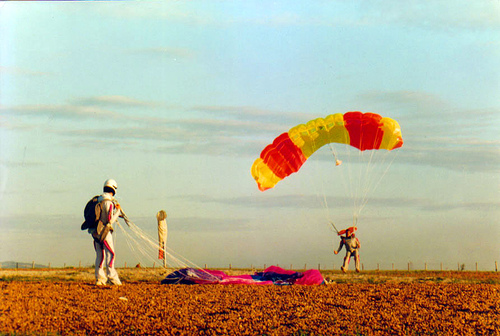


Accuracy :80.0 %


In [22]:
search_images(Image.open(os.path.join(img_dir,'107318069_e9f2ef32de.jpg')),k=5)

#CAPTION -> CAPTION

In [23]:
generate_clip_captions('A group of hot air balloons lit up at night',k=5)


Results: 
A group of hot air balloons lit up at night .
A crowd watching air balloons at night .
Seven large balloons are lined up at nighttime near a crowd .
A group of people are firing up a hot air balloon .
A hot air balloon just off the ground surrounded by people .

Bleu score is 0.8181818181818182


#IMAGE -> CAPTION

Query: 


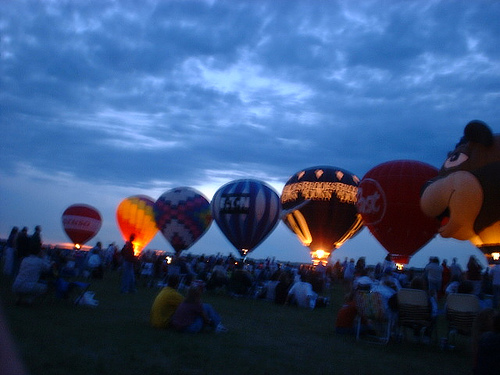


Results: 
Seven large balloons are lined up at nighttime near a crowd .
A group of hot air balloons lit up at night .
A crowd surrounds a grounded hot air balloon .
A crowd watching air balloons at night .
A group of people climb into a hot air balloon .

Bleu score is 0.75


In [24]:
generate_clip_captions(Image.open(os.path.join(img_dir,'107318069_e9f2ef32de.jpg')),k=5)

#Sentence transformers

https://www.sbert.net/

https://github.com/UKPLab/sentence-transformers

Bleu score example

This example was taken from deeplearning.ai's deeplearning specialisation, instead of bigrams we are calculating uni-grams here

In [25]:
from nltk.translate.bleu_score import corpus_bleu
actual=[[['the','cat','is','on','the','mat']]]
predicted =[['the','cat','the','cat','on','the','mat']]
# This example is taken from the deeplearning specialization by deepleaning.ai

In [26]:
actual_count=5
predicted_count=7
actual_count/predicted_count

0.7142857142857143

In [27]:
corpus_bleu(actual,predicted,weights=[1.0,0,0,0])

0.7142857142857143